# Case Study 2: Soft Sensor

## Objectives

After this tutorial you will be able to:

*   Link all the steps of a typical data science project
*   Predict a process parameter value in real-time by developing a soft sensor

<h2>Table of Contents</h2>

<ol>
    <li>
        <a href="#problem">Problem Definition</a>
    </li>
    <br>
    <li>
        <a href="#import">Data Collection</a>
    </li>
    <br>
    <li>
        <a href="#clean">Data Cleaning and Preparation</a>
    </li>
    <br>
    <li>
        <a href="#eda">Exploratory Data Analysis</a>
    </li>
    <br>
    <li>
        <a href="#model">Model Development and Evaluation</a>
    </li>
    <br>
    <li>
        <a href="#deploy">Deployment and Communication</a>
    </li>
    <br>
</ol>


<hr id="problem">

<h2>1. Problem Definition</h2>

<h3>Background:</h3>

In a distillation column, accurately measuring the composition of the bottom stream is crucial for process optimization and control. However, direct online measurement can be expensive, cumbersome, or even impossible for certain components. This raises the challenge of predicting the bottom stream composition using readily available data, like temperature readings from various trays within the column.


<div style="text-align: center;">
    <img src="distillation.png" height="500px">
</div>

<h3>Data</h3>

The data provided consists of temperature readings from different trays with their corresponding measured bottom stream composition at different conditions.

Process parameters:
- T12, C
- T27, C
- T42, C
- X_B, -

<h3>Goal:</h3>

**Develop a data-driven soft sensor:**  
This sensor will estimate the composition of the bottom stream (particularly the key component) based on temperature measurements from multiple trays within the distillation column.


<hr id="import">

<h2>2. Data Collection</h2>

Import the `Pandas` library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read the data from `data.csv` into a `Pandas DataFrame`

In [26]:
# Read in the data
df = pd.read_csv('distillation_data.csv')
df.head()

,"T12, C","T27, C","T42, C",XB
0,30.00,45.00,67.00,0.001077
1,30.98,45.63,67.32,0.001170
2,31.27,45.99,67.44,0.001189
3,31.91,46.87,67.89,0.001223
4,32.90,47.57,68.02,0.001379


<hr id="clean">

<h2>3. Data Cleaning and Preparation</h2>

<h5 id="clean-missing">Handle missing values</h5>

Identify missing values

In [27]:
# get more info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T12, C  542 non-null    float64
 1   T27, C  542 non-null    float64
 2   T42, C  541 non-null    float64
 3   XB      542 non-null    float64
dtypes: float64(4)
memory usage: 17.1 KB


In [28]:
# find the number of missing values in each column
df.isna().sum()

T12, C    1
T27, C    1
T42, C    2
XB        1
dtype: int64

Drop rows with "NaN" from certain columns

In [29]:
# drop the rows with missing values in the output column
df.dropna(subset=['XB'], inplace=True)

# replace the missing values in the input columns with the mean of the previous and next values
df.interpolate(method='linear', inplace=True)

df.loc[25:35]

,"T12, C","T27, C","T42, C",XB
25,42.820,57.01,80.51,0.001968
26,42.920,57.53,80.55,0.002236
27,43.040,57.73,80.81,0.002059
28,43.395,58.31,81.42,0.002186
29,43.750,58.74,82.40,0.002213
30,44.270,59.53,83.05,0.002245
31,44.760,60.03,83.28,0.002377
32,44.810,60.95,83.87,0.002511
33,45.520,60.99,83.91,0.002586
34,46.490,61.82,84.71,0.002507


<h5 id="clean-duplicates">Remove duplicates</h5>

In [30]:
# find the number of duplicate rows
df.duplicated().sum()

3

In [31]:
# drop the duplicate rows
df.drop_duplicates(inplace=True)

<h5 id="clean-standardize">Standardize data</h5>

In [32]:
# convert all the columns to float
df = df.astype(float)

<h5>Validate cleaned data</h5>

In [33]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 539 entries, 0 to 542
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T12, C  539 non-null    float64
 1   T27, C  539 non-null    float64
 2   T42, C  539 non-null    float64
 3   XB      539 non-null    float64
dtypes: float64(4)
memory usage: 21.1 KB


In [34]:
# check for duplicates
df.duplicated().sum()

0

<hr id="eda">

<h2>4. Exploratory Data Analysis</h2>

<h3>Descriptive Analysis</h3>

In [35]:
df_desc = df.describe()
df_desc

,"T12, C","T27, C","T42, C",XB
count,539.000000,539.000000,539.000000,539.000000
mean,167.392384,176.746215,203.157653,0.039028
std,79.624091,76.167664,80.238988,0.030611
min,30.000000,45.000000,67.000000,0.001077
25%,99.265000,111.030000,135.065000,0.010935
50%,167.050000,178.210000,202.840000,0.032444
75%,236.225000,241.125000,270.510000,0.062642
max,300.880000,308.400000,490.150000,0.107951


#### Temperature

Box plot

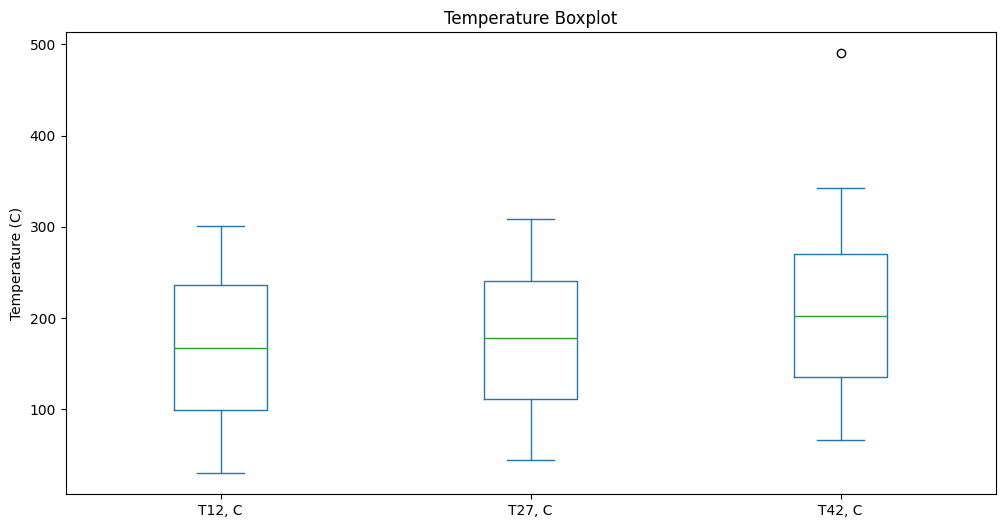

In [36]:
# box plot
df[['T12, C', 'T27, C', 'T42, C']].plot(kind='box', figsize=(12, 6), title='Temperature Boxplot', ylabel='Temperature (C)')
plt.show()

Remove outliers

In [37]:
# remove outliers for all columns
for col in df.columns:
    iqr = df_desc.loc['75%', col] - df_desc.loc['25%', col]
    upper_bound = df_desc.loc['75%', col] + 1.5 * iqr
    lower_bound = df_desc.loc['25%', col] - 1.5 * iqr
    df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]

Remove impractical entries

In [38]:
# find entries with T12 > T27 or T27 > T42
df[(df['T12, C'] > df['T27, C']) | (df['T27, C'] > df['T42, C'])]

,"T12, C","T27, C","T42, C",XB
275,190.34,179.96,203.73,0.033070
401,234.03,239.55,220.50,0.064195


In [39]:
# remove the found entries
df = df[(df['T12, C'] < df['T27, C']) & (df['T27, C'] < df['T42, C'])]
df.describe()

,"T12, C","T27, C","T42, C",XB
count,536.000000,536.000000,536.000000,536.000000
mean,166.983218,176.386231,202.588797,0.038879
std,79.590442,76.134138,79.495650,0.030563
min,30.000000,45.000000,67.000000,0.001077
25%,98.862500,110.685000,134.722500,0.010918
50%,165.830000,177.660000,201.785000,0.032325
75%,236.012500,241.007500,270.320000,0.062478
max,300.880000,308.400000,343.080000,0.107951


#### Bottom Composition

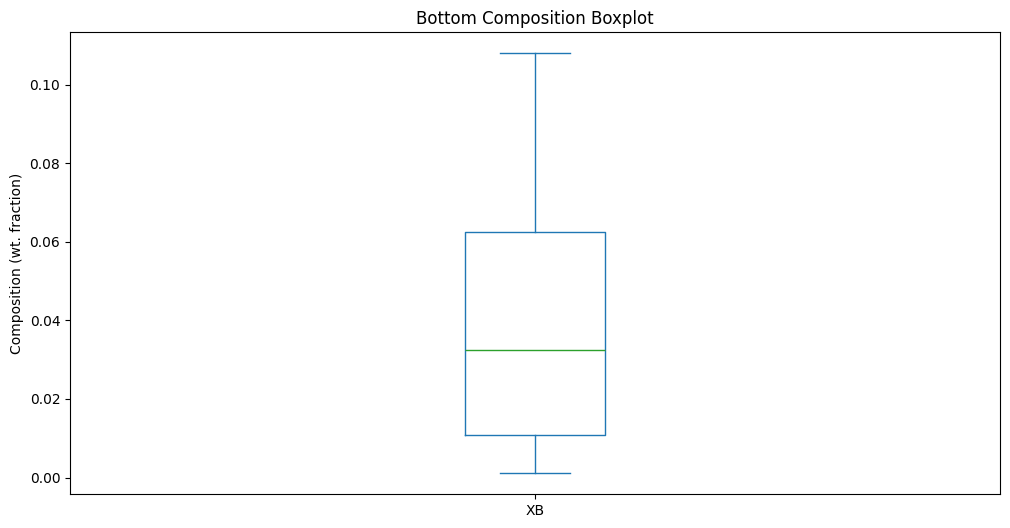

In [40]:
df['XB'].plot(kind='box', figsize=(12, 6), title='Bottom Composition Boxplot', ylabel='Composition (wt. fraction)')
plt.show()

<h3>Correlation Analysis</h3>

Calculate correlation between parameters

In [41]:
# calculate correlation matrix
corr_matrix = df.corr()
corr_matrix

,"T12, C","T27, C","T42, C",XB
"T12, C",1.000000,0.999785,0.999698,0.979061
"T27, C",0.999785,1.000000,0.999650,0.978558
"T42, C",0.999698,0.999650,1.000000,0.981893
XB,0.979061,0.978558,0.981893,1.000000


Visualize the correlation between parameters

<Axes: >

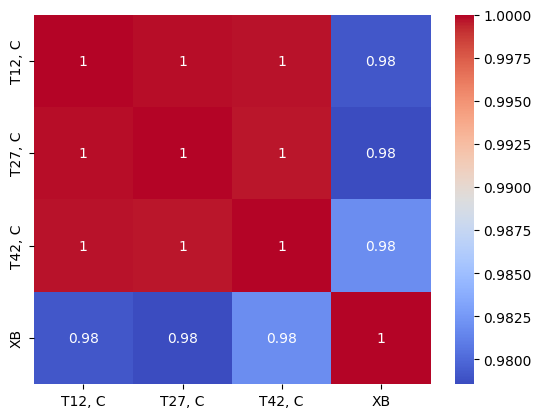

In [42]:
# plot correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Visualize the correlation trends

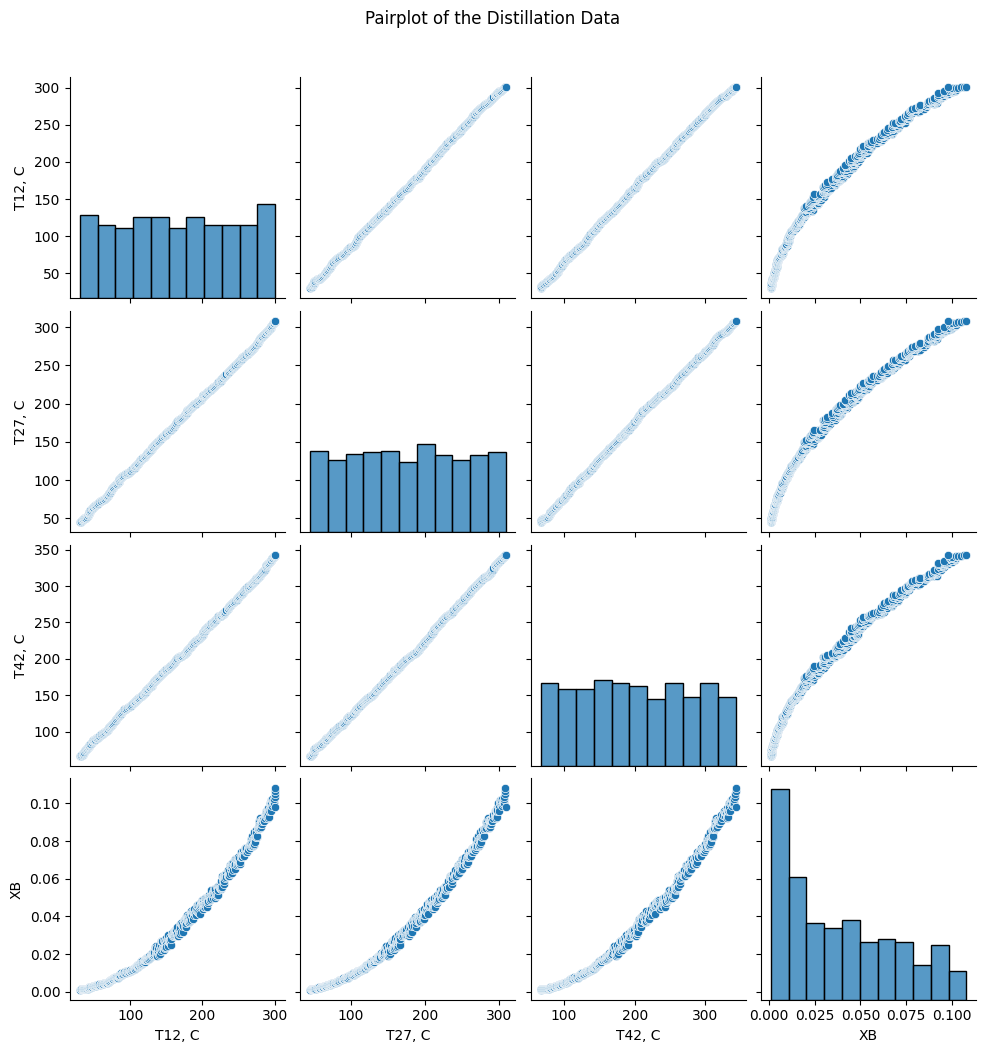

In [43]:
# plot scatter matrix (pairplot)
sns.pairplot(df, diag_kind='hist')

# add figure title
plt.suptitle('Pairplot of the Distillation Data', y=1.05)

plt.show()

<hr id="model">

<h2>5. Model Development and Evaluation</h2>

Let's first try linear regression to fit `Temperature Readings` vs `Bottom Composition`

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# create a linear regression model
lr = LinearRegression()

# split the data into training and testing sets
X = df.drop(columns=['XB'])
Y = df['XB']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# fit the model to the training data
lr.fit(X_train, Y_train)

# make predictions using the testing set
Y_pred = lr.predict(X_test)

# print the coefficients
print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)

Coefficients: 
 [-0.00091038 -0.00107691  0.0023218 ]
Intercept: 
 -0.0897094075317188


Evaluate the linear model using the following metrics:
- Mean Squared Error (MSE)
- Coefficient of Determination (R2)

In [45]:
# evaluate the model
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(Y_test, Y_pred)))
print('Coefficient of determination (R2): {:.2f}'.format(r2_score(Y_test, Y_pred)))

Mean squared error (MSE): 0.00
Coefficient of determination (R2): 0.98


#### Visualize model results

**1. Predicted vs Actual Plot**

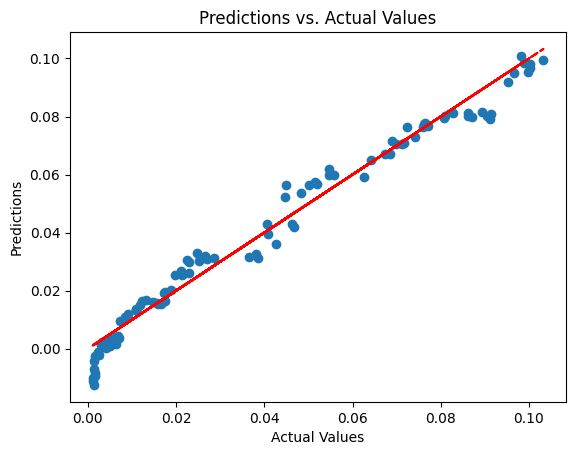

In [46]:
# plot the predictions vs. the actual values
plt.scatter(Y_test, Y_pred)
plt.plot(Y_test, Y_test, '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. Actual Values')
plt.show()

**2. Residuals Plot**

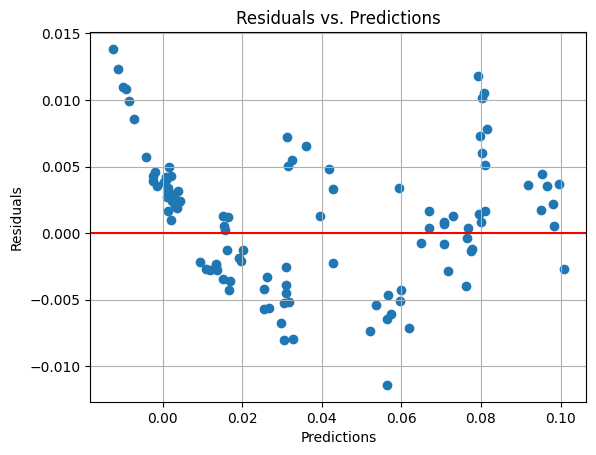

In [47]:
# plot the residuals
plt.scatter(Y_pred, Y_test - Y_pred)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')
plt.grid()

# plot zero error line
plt.axhline(0, color='r')

plt.show()

<p style="color:red;">*The model performs poorly around <code>X_B ~ 10^-3</code></p>

#### Let's try polynomial regression

In [48]:
# non-linear regression
from sklearn.preprocessing import PolynomialFeatures

# create a polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
lr_poly = LinearRegression()

# split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

# fit the model to the training data
lr_poly.fit(X_train, Y_train)

# make predictions using the testing set
Y_pred = lr_poly.predict(X_test)

# print the coefficients
print('Coefficients: \n', lr_poly.coef_)
print('Intercept: \n', lr_poly.intercept_)

Coefficients: 
 [ 0.00000000e+00  5.00137056e-03 -2.61073671e-04 -4.75245347e-03
  5.86002031e-05  3.59275294e-05 -1.51713116e-04 -3.41413187e-05
  3.31650481e-05  5.93406084e-05]
Intercept: 
 0.08732281322905927


In [49]:
# evaluate the model
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(Y_test, Y_pred)))
print('Coefficient of determination (R2): {:.2f}'.format(r2_score(Y_test, Y_pred)))

Mean squared error (MSE): 0.00
Coefficient of determination (R2): 1.00


#### Visualize model results

**1. Predicted vs Actual Plot**

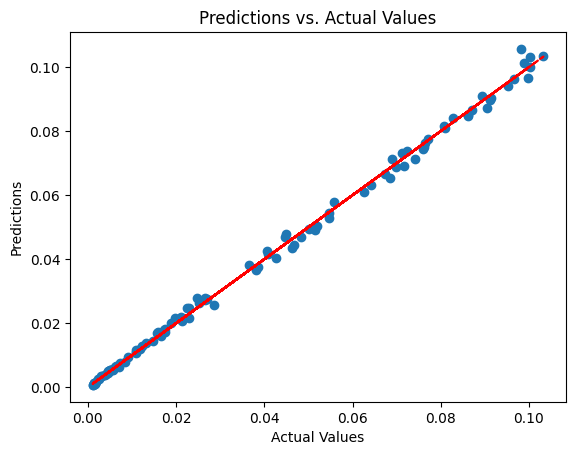

In [50]:
# plot the predictions vs. the actual values
plt.scatter(Y_test, Y_pred)
plt.plot(Y_test, Y_test, '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. Actual Values')
plt.show()

**2. Residuals Plot**

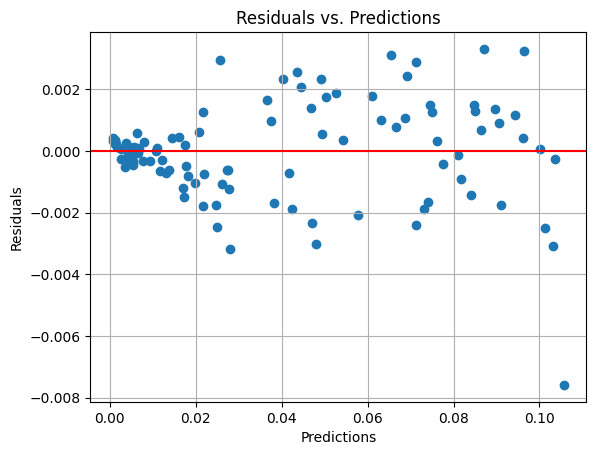

In [51]:
# plot the residuals
plt.scatter(Y_pred, Y_test - Y_pred)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')
plt.grid()

# plot zero error line
plt.axhline(0, color='r')

plt.show()

<p style="color:green;">*The polynomial model performs better than the linear model</p>

<hr id="deploy">

<h2>6. Deployment and Communication</h2>

The findings of the project can be deployed in a dashboard.  

They can also be presented in a report format for written reporting or presentation purposes.  
The report should contain the following sections:
1. **Title Page**  
   *the title, name, and date*
2. **Outline (table of contents)**  
   *the different sections of the report (with page numbers for printed report)*
3. **Executive Summary**  
   *a summary/overview of the problem, methodology, findings, and conclusions*
4. **Introduction**  
   *problem statement and background*
5. **Methodology**  
   *description of the different data science project steps (data collection, cleaning, exploration, different models tested, etc.)*
6. **Results**  
   *the findings with visualization charts, etc.*
7. **Discussion**  
   *analysis of the findings*
8. **Conclusion**  
   *drawn conclusions based on the findings*
9. **Appendix**  
   *any supporting data, charts, etc. that were not used in the report but could be useful to review (if any)*


<hr style="margin-top: 4rem;">
<h2>Author</h2>

<a href="https://github.com/SamerHany">Samer Hany</a>

<h2>References</h2>
<a href="https://www.w3schools.com/python/default.asp">w3schools.com</a>